In [2]:
import math
import random
import numpy as np
import gym
from gym import Env, spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from pythermalcomfort.models import pmv_ppd
from datetime import timedelta
from typing import Tuple
import pygame
import pandas as pd

In [20]:
class BuildingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, alpha=1, beta=1, EER=11):
        super(BuildingEnv, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.EER = EER
        self.room_width, self.room_height = 800, 600

        self.action_space = spaces.Discrete(9)  # actions are temperature setpoints from 22°C to 30°C
        low = np.array([-10.0, 0.0, -3.0])  # [Outdoor Temp, Occupancy, Aggregated PMV]
        high = np.array([50.0, 1.0, 3.0])
        self.observation_space = spaces.Box(low, high)

        self.time_step = 0
        self.max_steps = 48  # each step is 30 minutes, 48 steps in a day

        self.indoor_temp = 26.0
        self.setpoint_temp = 26.0
        self.outdoor_temp = self.generate_outdoor_temperature()
        self.occupancy_level = self.generate_occupancy_level()

        self.num_users = self.generate_num_users()
        self.users = self.generate_users()

        self.user_feedback = self.generate_user_feedback()
        self.hvac_power = 0.0

        self.history = {
            'indoor_temp': [], 'outdoor_temp': [], 'hvac_power': [],
            'user_feedback': [], 'occupancy': [], 'time': []
        }

        pygame.init()
        self.screen = pygame.display.set_mode((self.room_width, self.room_height))
        pygame.display.set_caption('Room Simulation')

    def generate_outdoor_temperature(self):
        time_of_day = (self.time_step % self.max_steps) / self.max_steps * 24.0
        temp = 28 + 6 * np.sin((time_of_day - 14) * np.pi / 12)  # peaks at 2 PM
        return temp + np.random.normal(0, 1.0)

    def generate_occupancy_level(self):
        time_of_day = (self.time_step % self.max_steps) / self.max_steps * 24.0
        if 9 <= time_of_day < 12 or 13 <= time_of_day < 17:  # normal work hours
            occupancy = np.random.uniform(0.5, 0.8)
        elif 12 <= time_of_day < 13:  # lunch hour (peak)
            occupancy = np.random.uniform(0.8, 1.0)
        elif 8 <= time_of_day < 9 or 17 <= time_of_day < 18:  # transition hours
            occupancy = np.random.uniform(0.2, 0.5)
        else:  # off hours
            occupancy = np.random.uniform(0.0, 0.1)
        return occupancy

    def generate_num_users(self):
        max_users = 100
        return int(self.occupancy_level * max_users)

    def generate_users(self):
        users = []
        for _ in range(self.num_users):
            user = {
                'x': random.randint(50, self.room_width - 50),
                'y': random.randint(50, self.room_height - 50),
                'met': np.random.uniform(1.0, 1.5),
                'clo': np.random.uniform(0.5, 1.0)
            }
            users.append(user)
        return users

    def generate_user_feedback(self):
        if self.num_users == 0:
            return 0  
        pmv_values = []
        for user in self.users:
            met = user['met']
            clo = user['clo']
            pmv = self.calculate_pmv(met, clo)
            pmv_values.append(pmv)
        aggregated_pmv = np.mean(pmv_values)
        return aggregated_pmv

    def calculate_pmv(self, met, clo):
        tdb = self.indoor_temp
        tr = tdb  # mean radiant temperature
        rh = 50.0  # relative humidity
        v = 0.1  # air velocity

        pmv_result = pmv_ppd(tdb=tdb, tr=tr, vr=v, rh=rh, met=met, clo=clo, standard='ASHRAE')
        return pmv_result['pmv']

    def step(self, action, constant_setpoint=None):
        if constant_setpoint is not None:
            self.setpoint_temp = constant_setpoint
        else:
            self.setpoint_temp = 22 + action

        temp_difference = self.indoor_temp - self.setpoint_temp
        self.hvac_power = abs(temp_difference) * 10 / self.EER  # simplified power model

        outdoor_influence = (self.outdoor_temp - self.indoor_temp) * 0.1
        hvac_influence = (self.setpoint_temp - self.indoor_temp) * 0.5
        self.indoor_temp += outdoor_influence + hvac_influence

        self.time_step += 1
        done = self.time_step >= self.max_steps
        self.outdoor_temp = self.generate_outdoor_temperature()
        self.occupancy_level = self.generate_occupancy_level()
        self.num_users = self.generate_num_users()
        self.users = self.generate_users()

        self.user_feedback = self.generate_user_feedback()

        if self.num_users == 0:
            reward = -self.beta * (self.hvac_power / 100.0)  # only energy consumption penalty
        else:
            comfort_penalty = abs(self.user_feedback) * self.occupancy_level
            energy_penalty = self.hvac_power / 100.0  # normalize energy consumption
            reward = -(self.alpha * comfort_penalty + self.beta * energy_penalty)

        self.history['indoor_temp'].append(self.indoor_temp)
        self.history['outdoor_temp'].append(self.outdoor_temp)
        self.history['hvac_power'].append(self.hvac_power)
        self.history['user_feedback'].append(self.user_feedback)
        self.history['occupancy'].append(self.occupancy_level)
        self.history['time'].append(self.time_step)

        state = np.array([self.outdoor_temp, self.occupancy_level, self.user_feedback], dtype=np.float32)
        return state, reward, done, {}

    def reset(self):
        self.time_step = 0
        self.indoor_temp = 26.0
        self.setpoint_temp = 26.0
        self.outdoor_temp = self.generate_outdoor_temperature()
        self.occupancy_level = self.generate_occupancy_level()
        self.num_users = self.generate_num_users()
        self.users = self.generate_users()
        self.user_feedback = self.generate_user_feedback()
        self.hvac_power = 0.0

        for key in self.history.keys():
            self.history[key] = []

        state = np.array([self.outdoor_temp, self.occupancy_level, self.user_feedback], dtype=np.float32)
        return state

    def render(self):
        self.screen.fill((255, 255, 255))  
        font = pygame.font.SysFont(None, 24)

        for user in self.users:
            pygame.draw.circle(self.screen, (0, 255, 0), (user['x'], user['y']), 5)  # grreen circle for user
            met_clo_text = font.render(f"Met: {user['met']:.2f} Clo: {user['clo']:.2f}", True, (0, 0, 0))
            self.screen.blit(met_clo_text, (user['x'] - 40, user['y'] - 20))

        info_texts = [
            f"Time: {self.time_step * 0.5:.1f} hours",
            f"Indoor Temp: {self.indoor_temp:.2f}°C",
            f"Outdoor Temp: {self.outdoor_temp:.2f}°C",
            f"Setpoint: {self.setpoint_temp:.2f}°C",
            f"Occupancy: {self.occupancy_level:.2f}",
            f"Users: {self.num_users}",
            f"PMV: {self.user_feedback:.2f}",
            f"HVAC Power: {self.hvac_power:.2f} kW"
        ]

        for i, text in enumerate(info_texts):
            text_surface = font.render(text, True, (0, 0, 0))
            self.screen.blit(text_surface, (10, 10 + i * 30))

        pygame.display.flip()  # Update the display

In [21]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

class DQNAgent:
    def __init__(self, n_observations, n_actions, device, memory_size=10000, batch_size=64, gamma=0.99, 
                 eps_start=0.9, eps_end=0.05, eps_decay=2000, tau=0.005, lr=1e-4):
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.tau = tau
        self.lr = lr

        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayMemory(memory_size)

        self.steps_done = 0

    def select_action(self, state):
        # epsilon-greedy strategy
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=self.device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), 
                                      device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * self.tau + \
                                         target_net_state_dict[key] * (1 - self.tau)
        self.target_net.load_state_dict(target_net_state_dict)

    def memorize(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)

In [22]:
def train(agent, env, constant_setpoint, episodes, target_update_frequency=10, render_interval=1):
    dqn_rewards = []
    baseline_rewards = []

    for e in range(episodes):
        # DQN training
        state = env.reset()
        state = torch.tensor([state], device=agent.device, dtype=torch.float32)
        total_dqn_reward = 0.0

        for time_step in range(env.max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=agent.device, dtype=torch.float32)

            next_state = torch.tensor([next_state], device=agent.device, dtype=torch.float32) if not done else None
            agent.memorize(state, action, next_state, reward)
            state = next_state
            total_dqn_reward += reward.item()
            agent.optimize_model()

            if time_step % render_interval == 0:
                env.render()  # render the room and users

            if done:
                break

        dqn_rewards.append(total_dqn_reward)

        if e % target_update_frequency == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        env.reset()
        total_baseline_reward = 0.0

        for time_step in range(env.max_steps):
            state, reward, done, _ = env.step(0, constant_setpoint=constant_setpoint)
            total_baseline_reward += reward

            if time_step % render_interval == 0:
                env.render()  # render the room 

            if done:
                break

        baseline_rewards.append(total_baseline_reward)

        print(f"Episode {e+1}/{episodes}, DQN Total Reward: {total_dqn_reward:.2f}, "
              f"Baseline Total Reward: {total_baseline_reward:.2f}")
    return dqn_rewards, baseline_rewards

def plot_rewards(dqn_rewards, baseline_rewards):
    import matplotlib.pyplot as plt
    plt.plot(dqn_rewards, label="DQN")
    plt.plot(baseline_rewards, label="Constant Setpoint", color="red")
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('DQN vs Constant Setpoint: Total Reward per Episode')
    plt.legend()
    plt.show()

Episode 1/300, DQN Total Reward: -12.70, Baseline Total Reward: -4.92
Episode 2/300, DQN Total Reward: -12.34, Baseline Total Reward: -4.94
Episode 3/300, DQN Total Reward: -9.53, Baseline Total Reward: -5.01
Episode 4/300, DQN Total Reward: -9.80, Baseline Total Reward: -4.64
Episode 5/300, DQN Total Reward: -6.19, Baseline Total Reward: -4.88
Episode 6/300, DQN Total Reward: -14.04, Baseline Total Reward: -4.78
Episode 7/300, DQN Total Reward: -11.77, Baseline Total Reward: -4.96
Episode 8/300, DQN Total Reward: -10.16, Baseline Total Reward: -5.05
Episode 9/300, DQN Total Reward: -9.28, Baseline Total Reward: -4.91
Episode 10/300, DQN Total Reward: -10.73, Baseline Total Reward: -5.01
Episode 11/300, DQN Total Reward: -9.92, Baseline Total Reward: -4.92
Episode 12/300, DQN Total Reward: -6.51, Baseline Total Reward: -5.31
Episode 13/300, DQN Total Reward: -7.94, Baseline Total Reward: -5.16
Episode 14/300, DQN Total Reward: -11.51, Baseline Total Reward: -5.17
Episode 15/300, DQN To

Exception ignored in: <function Env.__del__ at 0x000002740E254180>
Traceback (most recent call last):
  File "c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py", line 202, in __del__
    self.close()
  File "c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py", line 167, in close
    self.render(close=True)
TypeError: BuildingEnv.render() got an unexpected keyword argument 'close'


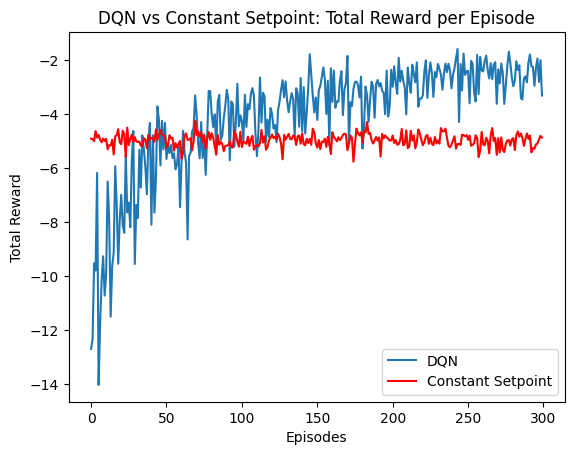

In [23]:
env = BuildingEnv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(n_observations=env.observation_space.shape[0], n_actions=env.action_space.n, device=device)
episodes = 300
constant_setpoint_temp = 24.0  # can be changed.
dqn_rewards, baseline_rewards = train(agent, env, constant_setpoint_temp, episodes)
plot_rewards(dqn_rewards, baseline_rewards)

# Part 2

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


NameError: name 'gym' is not defined

In [43]:
def train(agent, env, constant_setpoint, episodes, target_update_frequency=10):
    dqn_rewards = []
    baseline_rewards = []

    for e in range(episodes):
        # DQN training
        state = env.reset()
        state = torch.tensor([state], device=agent.device, dtype=torch.float32)
        total_dqn_reward = 0.0

        for time_step in range(env.max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=agent.device, dtype=torch.float32)

            next_state = torch.tensor([next_state], device=agent.device, dtype=torch.float32) if not done else None
            agent.memorize(state, action, next_state, reward)
            state = next_state
            total_dqn_reward += reward.item()
            agent.optimize_model()

            if done:
                break

        dqn_rewards.append(total_dqn_reward)

        if e % target_update_frequency == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        # setpoint training (constant temperature setpoint)
        env.reset()
        total_baseline_reward = 0.0

        for time_step in range(env.max_steps):
            state, reward, done, _ = env.step(0, constant_setpoint=constant_setpoint)
            total_baseline_reward += reward

            if done:
                break

        baseline_rewards.append(total_baseline_reward)

        print(f"Episode {e+1}/{episodes}, DQN Total Reward: {total_dqn_reward:.2f}, "
              f"Baseline Total Reward: {total_baseline_reward:.2f}")
    return dqn_rewards, baseline_rewards


def plot_rewards(dqn_rewards, baseline_rewards):
    import matplotlib.pyplot as plt
    plt.plot(dqn_rewards, label="DQN")
    plt.plot(baseline_rewards, label="Constant Setpoint", color="red")
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('DQN vs Constant Setpoint: Total Reward per Episode')
    plt.legend()
    plt.show()

Episode 1/300, DQN Total Reward: -20.62, Baseline Total Reward: -9.90
Episode 2/300, DQN Total Reward: -18.29, Baseline Total Reward: -9.11
Episode 3/300, DQN Total Reward: -18.81, Baseline Total Reward: -9.46
Episode 4/300, DQN Total Reward: -18.59, Baseline Total Reward: -9.58
Episode 5/300, DQN Total Reward: -14.84, Baseline Total Reward: -8.88
Episode 6/300, DQN Total Reward: -17.43, Baseline Total Reward: -9.25
Episode 7/300, DQN Total Reward: -17.50, Baseline Total Reward: -9.47
Episode 8/300, DQN Total Reward: -18.85, Baseline Total Reward: -8.87
Episode 9/300, DQN Total Reward: -14.54, Baseline Total Reward: -10.27
Episode 10/300, DQN Total Reward: -14.92, Baseline Total Reward: -9.79
Episode 11/300, DQN Total Reward: -13.42, Baseline Total Reward: -9.99
Episode 12/300, DQN Total Reward: -19.32, Baseline Total Reward: -9.38
Episode 13/300, DQN Total Reward: -17.65, Baseline Total Reward: -9.87
Episode 14/300, DQN Total Reward: -13.32, Baseline Total Reward: -8.97
Episode 15/300

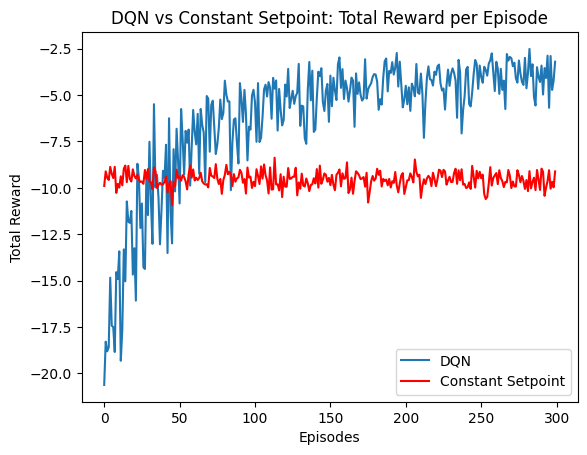

: 

In [44]:
env = BuildingEnv()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(n_observations=env.observation_space.shape[0], n_actions=env.action_space.n, device=device)
episodes = 300
constant_setpoint_temp = 24.0  # can be changed.
dqn_rewards, baseline_rewards = train(agent, env, constant_setpoint_temp, episodes)
plot_rewards(dqn_rewards, baseline_rewards)